In [1]:
import numpy as np
np.logspace(1, 9, 5, base=2)

array([   2.,    8.,   32.,  128.,  512.])

In [1]:
from Definiciones import *
import pandas as pd

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

train_data = pd.read_csv('Data/DMC_Train.csv', header=0)
test_data = pd.read_csv('Data/DMC_Test.csv', header=0)

numeric_coerce = train_data.select_dtypes(include=["object"]).drop(["csa"], axis=1).columns

train_data[numeric_coerce] = train_data[numeric_coerce].apply(lambda x: pd.to_numeric(x, errors='coerce'))
test_data[numeric_coerce] = test_data[numeric_coerce].apply(lambda x: pd.to_numeric(x, errors='coerce'))

float_coerce = train_data.select_dtypes(include=["int64"]).columns
float_coerce = [x for x in float_coerce if x not in ['churn', 'customer']]
train_data[float_coerce] = train_data[float_coerce].astype(float)
test_data[float_coerce] = test_data[float_coerce].astype(float)

target_var = "churn"
predictors = [x for x in test_data.columns.tolist() if x not in ['customer', 'csa']]
descriptors = ['incmiss', 'income', 'marryno', 'marryun', 'marryyes', 
               'occcler', 'occcrft', 'occhmkr', 'occprof', 'occret', 
               'occself', 'occstud', 'ownrent', 'prizmrur', 'prizmtwn', 
               'prizmub', 'credita', 'creditaa', 'creditb', 'creditc', 
               'creditcd', 'creditde', 'creditgy', 'creditz', 'mcycle', 
               'pcown', 'rv', 'travel', 'truck']

business_vars = ['changem', 'changer', 'directas', 'mou', 'overage', 
                 'recchrge', 'roam', 'revenue', 'eqpdays', 'models', 
                 'phones', 'actvsubs', 'blckvce', 'callfwdv', 'callwait', 
                 'custcare', 'dropblk', 'dropvce', 'incalls', 'mailflag', 
                 'mailord', 'mailres', 'months', 'mourec', 'newcelln', 
                 'newcelly', 'opeakvce', 'outcalls', 'peakvce', 'refer', 
                 'refurb', 'retaccpt', 'retcall', 'retcalls', 'setprc', 
                 'setprcm', 'threeway', 'unansvce', 'uniqsubs', 'webcap']

C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\IPython\core\interactiveshell.py:2705: DtypeWarning: Columns (1,2,3,4,5,6,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#Creación de variables

def variable_creation(df):
    df["change_missing"] = df["changem"].isnull().astype(float)
    df["missing_mean_info"] = df["revenue"].isnull().astype(float)
    df["actvsubs_missing"] = (df["actvsubs"] == 0).astype(float)
    df.loc[df['actvsubs_missing'] == 1, "actvsubs"] = np.NaN
    df["age1_is_null"] = ((df["age1"].isnull()) | (df["age1"] == 0)).astype(float)
    df["age2_is_null"] = ((df['age2'].isnull()) | ((df['age2'] == 0) & (df['actvsubs'] > 1))).astype(float)
    df.loc[df["age1_is_null"] == 1, "age1"] = np.NaN
    df.loc[df["age2_is_null"] == 1, "age2"] = np.NaN
    geographic_info = df['csa'].str.extract('^(?P<first_city_code>.{3})(?P<second_city_code>.{3})(?P<geo_number>\d{3})')
    df = pd.concat([df, geographic_info], axis=1)
    return df

train_data = variable_creation(train_data)
test_data = variable_creation(test_data)

original_predictors = predictors
predictors = predictors + ["change_missing", "missing_mean_info", "age1_is_null", "age2_is_null", "actvsubs_missing", "first_city_code", "second_city_code"]
#, "geo_number"

C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [ ]:
#Joining with geographic information
airport_codes = pd.read_csv('Data/airports.csv', header=0)

train_data = pd.merge(train_data, airport_codes, left_on=['first_city_code'], right_on=['iata_code'], how='left')
test_data = pd.merge(test_data, airport_codes, left_on=['first_city_code'], right_on=['iata_code'], how='left')

In [71]:
test_data[test_data['ident'].isnull()]['first_city_code'].unique()

array(['MIL', 'KCY', 'NYC', 'NOL', 'SFR', 'OHI', 'CHI', 'HWI', 'NMX',
       'SDA', 'AWI', 'IPM', 'NVU'], dtype=object)

In [70]:
train_data[train_data['ident'].isnull()]['first_city_code'].unique()

array(['MIL', 'KCY', 'NYC', 'NOL', 'SFR', 'OHI', 'CHI', 'HWI', 'NMX',
       'SDA', 'IPM', 'NVU', 'AWI'], dtype=object)

In [3]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical(df):
    mask = ~(df["first_city_code"].isnull())
    first_city_encoder = LabelEncoder()
    df.loc[mask, "first_city_code"] = first_city_encoder.fit_transform(df.loc[mask, "first_city_code"])
    second_city_encoder = LabelEncoder()
    df.loc[mask, "second_city_code"] = second_city_encoder.fit_transform(df.loc[mask, "second_city_code"])
    return first_city_encoder, second_city_encoder

encode_categorical(train_data)
encode_categorical(test_data)

(LabelEncoder(), LabelEncoder())

In [4]:
#Imputación
from sklearn.preprocessing import Imputer

continuous_vars = ["changem", "changer", "directas", "mou", "overage", "recchrge", "roam", "revenue"]
train_data[continuous_vars], test_data[continuous_vars] = impute_train_test(train_data[continuous_vars], test_data[continuous_vars])

discrete_vars = ["age1", "age2", "eqpdays", "models", "phones", "actvsubs"]
train_data[discrete_vars], test_data[discrete_vars] = impute_train_test(train_data[discrete_vars], test_data[discrete_vars], is_discrete=True)

discrete_vars = ["first_city_code", "second_city_code"]
train_data[discrete_vars], test_data[discrete_vars] = impute_train_test(train_data[discrete_vars], test_data[discrete_vars], is_discrete=True, strategy='most_frequent')

In [5]:
#Age ratio calculation

train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age_ratio'] = \
    train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age1'] - train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age2']
train_data.loc[(train_data['age2'] == 0) | (train_data['age1'] != 0), 'age_ratio'] = 0
test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age_ratio'] = \
    test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age1'] / test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age2']
test_data.loc[(test_data['age2'] == 0) | (test_data['age1'] != 0), 'age_ratio'] = 0
predictors = predictors + ['age_ratio']

#train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age_difference'] = \
#    train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age1'] / train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age2']
#train_data.loc[(train_data['age2'] == 0) | (train_data['age1'] != 0), 'age_difference'] = 0
#test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age_difference'] = \
#    test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age1'] - test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age2']
#test_data.loc[(test_data['age2'] == 0) | (test_data['age1'] != 0), 'age_difference'] = 0
#predictors = predictors + ['age_difference']

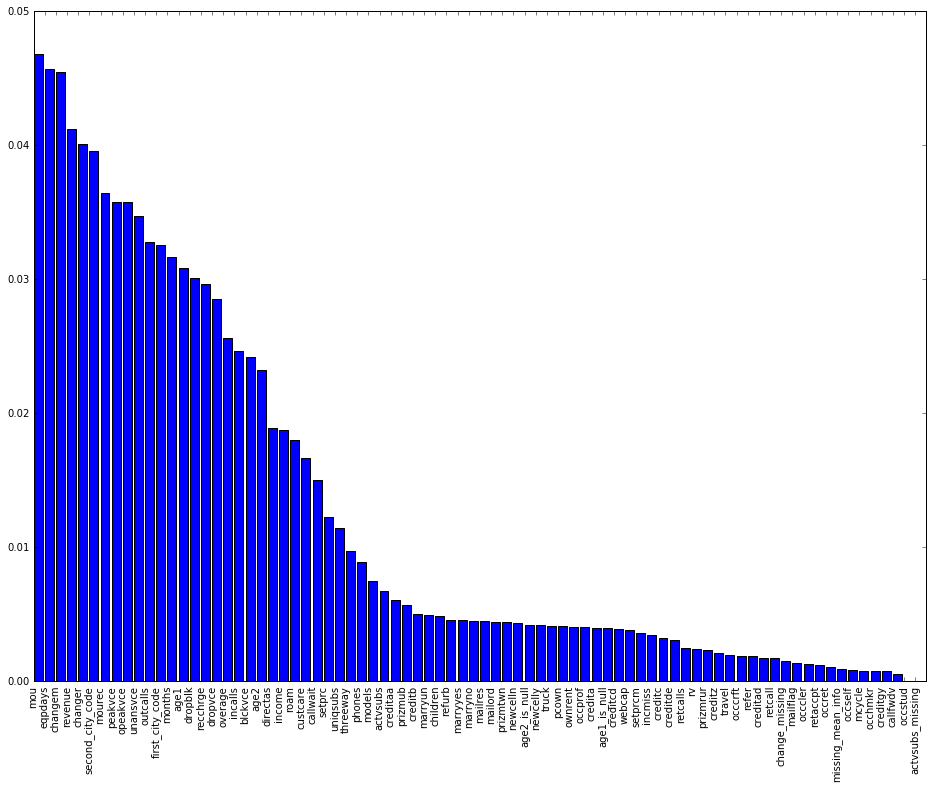

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# Perform feature selection
#selector = SelectKBest(f_classif, k='all')
#selector.fit(train_data[predictors], train_data[target_var])
selector = RandomForestClassifier(n_estimators = 400, max_features= 'auto', min_samples_leaf = 2, n_jobs=-2)
selector.fit(train_data[predictors], train_data[target_var])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = selector.feature_importances_

values = sorted(zip(predictors, scores), key=(lambda x: x[1]), reverse=True)

fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
ax.bar(range(len([x[0] for x in values])), [x[1] for x in values])
plt.xticks(range(len([x[0] for x in values])), [x[0] for x in values], rotation='vertical')

plt.show()

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

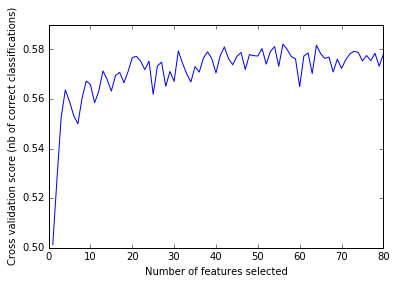

['revenue',
 'mou',
 'recchrge',
 'directas',
 'overage',
 'roam',
 'changem',
 'changer',
 'dropvce',
 'blckvce',
 'unansvce',
 'custcare',
 'threeway',
 'mourec',
 'outcalls',
 'incalls',
 'peakvce',
 'opeakvce',
 'dropblk',
 'callfwdv',
 'callwait',
 'months',
 'uniqsubs',
 'phones',
 'eqpdays',
 'age1',
 'age2',
 'creditaa',
 'creditb',
 'creditde',
 'creditgy',
 'refurb',
 'webcap',
 'truck',
 'rv',
 'occstud',
 'occhmkr',
 'occret',
 'ownrent',
 'marryun',
 'mailres',
 'pcown',
 'retcalls',
 'newcelln',
 'refer',
 'income',
 'mcycle',
 'creditad',
 'setprcm',
 'setprc',
 'retcall',
 'change_missing',
 'missing_mean_info',
 'age2_is_null',
 'first_city_code',
 'second_city_code']

In [47]:
#Feature Selection

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=GradientBoostingClassifier(n_estimators=64, max_features= 0.4, min_samples_split= 4), step=1, cv=StratifiedKFold(y, 2),
              scoring='roc_auc', verbose=2)

X = train_data[predictors]
y = train_data[target_var]
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

results = sorted(zip(predictors, rfecv.support_, rfecv.ranking_), key= lambda x: x[2])

#print('\r\n'.join([str(r) for r in results]))

column_filter = zip(train_data[predictors].columns, rfecv.support_)
selected_columns = [col[0] for col in column_filter if col[1]]
X = train_data[selected_columns]
selected_columns

C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [80] are constant.
  UserWarning)


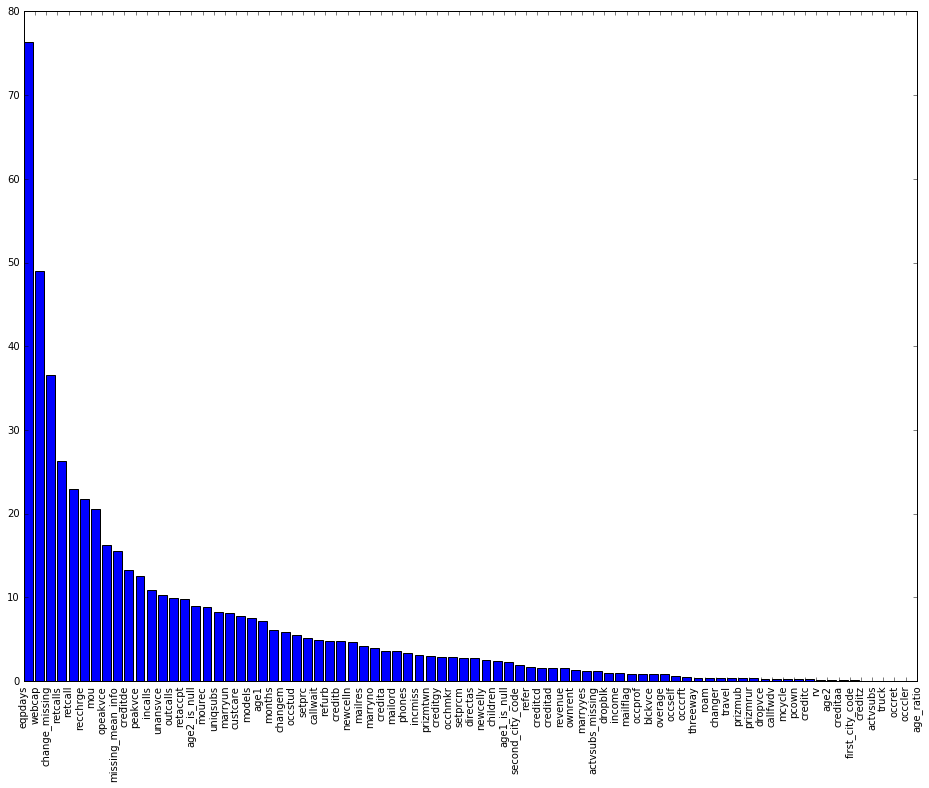

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection
selector = SelectKBest(f_classif, k='all')
selector.fit(train_data[predictors], train_data[target_var])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = selector.scores_

values = sorted(zip(predictors, scores), key=(lambda x: x[1]), reverse=True)

fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
ax.bar(range(len([x[0] for x in values])), [x[1] for x in values])
plt.xticks(range(len([x[0] for x in values])), [x[0] for x in values], rotation='vertical')

plt.show()

In [15]:
selected_columns = [x[0] for x in values if x[1] > 0.5]
selected_columns

['eqpdays',
 'webcap',
 'change_missing',
 'retcalls',
 'retcall',
 'recchrge',
 'mou',
 'opeakvce',
 'missing_mean_info',
 'creditde',
 'peakvce',
 'incalls',
 'unansvce',
 'outcalls',
 'retaccpt',
 'age2_is_null',
 'mourec',
 'uniqsubs',
 'marryun',
 'custcare',
 'models',
 'age1',
 'months',
 'changem',
 'occstud',
 'setprc',
 'callwait',
 'refurb',
 'creditb',
 'newcelln',
 'mailres',
 'marryno',
 'credita',
 'mailord',
 'phones',
 'incmiss',
 'prizmtwn',
 'creditgy',
 'occhmkr',
 'setprcm',
 'directas',
 'newcelly',
 'children',
 'age1_is_null',
 'second_city_code',
 'refer',
 'creditcd',
 'creditad',
 'revenue',
 'ownrent',
 'marryyes',
 'actvsubs_missing',
 'dropblk',
 'income',
 'mailflag',
 'occprof',
 'blckvce',
 'overage',
 'occself']

In [77]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.decomposition import PCA

params = [#[{'reduce_dim__whiten': [True],
          #  'reduce_dim__n_components': [None, 47],
          #  'svm__C': [0.1, 1, 10, 100], 
          #  'svm__gamma': [1, 0.1, 0.01, 0.001]}], #svm pbf
          #[{'reduce_dim__whiten': [True],
          #  'reduce_dim__n_components': [None, 47],
          #  'lin_svm__C': [0.1, 1, 10, 100], 
          #  'lin_svm__gamma': [1, 0.1, 0.01, 0.001]}], #svm linear
          #[{#'reduce_dim__whiten': [False],
          #  'etc__min_samples_split': [1, 2, 3, 4], 
          #  'etc__min_samples_leaf': [1, 2, 3, 4], 
          #  'etc__class_weight': [None, 'balanced']}], #Extra Trees Classifier
          [{#'reduce_dim__whiten': [False],
            'rfc__min_samples_split': [1, 2, 3, 4], 
            'rfc__min_samples_leaf': [1, 2, 3, 4], 
            'rfc__class_weight': [None, 'balanced']}], #random forest
          [{#'reduce_dim__whiten': [False],
            'abc__learning_rate': [0.5, 0.6, 0.7, 0.8, 0.9]}],
          [{#'reduce_dim__whiten': [False],
            'gbc__min_samples_split': [1, 2, 3, 4],
            'gbc__max_features': ['auto', 0.3, 0.4, 0.5]}]
         ]

classifiers = [#[#('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=100))),
                #('normalize', Normalizer()),
                #('svm', SVC(cache_size = 300))],
               #[('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=100))), 
                #('normalize', Normalizer()), 
                #('lin_svm', SVC(kernel='linear', cache_size = 500))],
               #[('etc', ExtraTreesClassifier(n_estimators = 700))],
               [('rfc', RandomForestClassifier(n_estimators = 500, random_state=1))],
               [('abc', AdaBoostClassifier(n_estimators = 500, random_state=1))],
               [('gbc', GradientBoostingClassifier(n_estimators = 500, random_state=1))]
              ]
#preliminary_steps = [('reduce_dim', PCA()), ('normalize', Normalizer())]
#preliminary_steps = [('reduce_dim', PCA())]
preliminary_steps = []
grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             classifiers, params, preliminary_steps, 
                             scoring='roc_auc',
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=10, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing rfc
Preparing to fit
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-2)]: Done 320 out of 320 | elapsed: 72.2min finished


Fitting completed
Best parameters set found on development set:
{'rfc__min_samples_split': 1, 'rfc__min_samples_leaf': 4, 'rfc__class_weight': None}
Best score set found on development set:
0.647381228522
Grid scores on development set:

0.613 (+/-0.048) for {'rfc__min_samples_split': 1, 'rfc__min_samples_leaf': 1, 'rfc__class_weight': None}
0.625 (+/-0.044) for {'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 1, 'rfc__class_weight': None}
0.622 (+/-0.038) for {'rfc__min_samples_split': 3, 'rfc__min_samples_leaf': 1, 'rfc__class_weight': None}
0.623 (+/-0.047) for {'rfc__min_samples_split': 4, 'rfc__min_samples_leaf': 1, 'rfc__class_weight': None}
0.625 (+/-0.043) for {'rfc__min_samples_split': 1, 'rfc__min_samples_leaf': 2, 'rfc__class_weight': None}
0.628 (+/-0.051) for {'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 2, 'rfc__class_weight': None}
0.612 (+/-0.042) for {'rfc__min_samples_split': 3, 'rfc__class_weight': None, 'rfc__min_samples_leaf': 2}
0.625 (+/-0.061) for

[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed: 11.1min finished


Fitting completed
Best parameters set found on development set:
{'abc__learning_rate': 0.5}
Best score set found on development set:
0.645297895189
Grid scores on development set:

0.645 (+/-0.062) for {'abc__learning_rate': 0.5}
0.628 (+/-0.074) for {'abc__learning_rate': 0.6}
0.634 (+/-0.041) for {'abc__learning_rate': 0.7}
0.631 (+/-0.058) for {'abc__learning_rate': 0.8}
0.627 (+/-0.053) for {'abc__learning_rate': 0.9}

Now testing gbc
Preparing to fit
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-2)]: Done 160 out of 160 | elapsed: 42.1min finished


Fitting completed
Best parameters set found on development set:
{'gbc__max_features': 0.4, 'gbc__min_samples_split': 2}
Best score set found on development set:
0.643216709622
Grid scores on development set:

0.635 (+/-0.065) for {'gbc__max_features': 'auto', 'gbc__min_samples_split': 1}
0.643 (+/-0.038) for {'gbc__max_features': 'auto', 'gbc__min_samples_split': 2}
0.640 (+/-0.019) for {'gbc__max_features': 'auto', 'gbc__min_samples_split': 3}
0.640 (+/-0.046) for {'gbc__max_features': 'auto', 'gbc__min_samples_split': 4}
0.629 (+/-0.042) for {'gbc__max_features': 0.3, 'gbc__min_samples_split': 1}
0.635 (+/-0.057) for {'gbc__max_features': 0.3, 'gbc__min_samples_split': 2}
0.638 (+/-0.043) for {'gbc__max_features': 0.3, 'gbc__min_samples_split': 3}
0.627 (+/-0.049) for {'gbc__max_features': 0.3, 'gbc__min_samples_split': 4}
0.632 (+/-0.040) for {'gbc__max_features': 0.4, 'gbc__min_samples_split': 1}
0.643 (+/-0.036) for {'gbc__max_features': 0.4, 'gbc__min_samples_split': 2}
0.637 (+/

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.decomposition import PCA

def add_cluster_feature(df, features, total_clusters, imputer_mbkm = None):
    normalizer = Normalizer()
    
    if imputer_mbkm is None:
        mbkm = MiniBatchKMeans(n_clusters=total_clusters, verbose=0, reassignment_ratio=0.3, n_init=40)
        normalized_train = normalizer.fit_transform(df[features])
        mbkm.fit(normalized_train)
    else:
        mbkm = imputer_mbkm
        
    normalized_df = normalizer.fit_transform(df[features])
    cluster_prediction = mbkm.predict(normalized_df)
    df['cluster'] = cluster_prediction
    return df, mbkm

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators=200)),
               ('abc', AdaBoostClassifier()),
               ('gbc', GradientBoostingClassifier())
              ]

#X = train_data[selected_columns + ['cluster']] 
#X = train_data[business_vars + ['cluster']]

params = [{'vtc__voting': ['soft']}]
preliminary_steps = []

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[selected_columns], train_data[target_var], 
                             algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  1.1min finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.628053407789
Grid scores on development set:

0.628 (+/-0.044) for {'vtc__voting': 'soft'}



In [82]:
#parámetros del mejor clasiffier

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.decomposition import PCA

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators = 500, class_weight='balanced', min_samples_split=2, min_samples_leaf=2)),
               ('abc', AdaBoostClassifier(n_estimators = 500, learning_rate= 0.9)),
               ('gbc', GradientBoostingClassifier(n_estimators = 500, max_features=0.4, min_samples_split=4)),
              ]

params = [{'vtc__voting': ['soft']}]
preliminary_steps = []

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  3.8min finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.615711626575
Grid scores on development set:

0.616 (+/-0.033) for {'vtc__voting': 'soft'}



In [5]:
%matplotlib inline

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp

cv = StratifiedKFold(y, n_folds=5)
classifier = VotingClassifier(estimators=classifiers, voting='soft')

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

clf = VotingClassifier(estimators=classifiers, voting='soft')
#clf = GradientBoostingClassifier(n_estimators = 1500, random_state=1, max_depth=12, min_samples_split=800,
#                                min_samples_leaf=51, max_features=14, learning_rate=0.05, subsample=0.85)
clf.fit(X, y)

#test_data['cluster'] = mbkm.predict(test_data[descriptors + ["change_missing", "age1_is_null", "age2_is_null", "missing_mean_info"]])

# The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
predictions = clf.predict_proba(test_data[predictors].astype(float))
predictionsdf = pd.DataFrame(data = predictions[:, 1],
                             index = test_data["customer"],
                             columns = ["churn"])
predictionsdf.to_csv("data/predictions.csv")

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.decomposition import PCA

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators = 700, class_weight='balanced', min_samples_split= 2, min_samples_leaf= 2)),
               ('abc', AdaBoostClassifier(n_estimators = 500, learning_rate= 0.9)),
               ('gbc', GradientBoostingClassifier(n_estimators = 500, max_features= 0.4, min_samples_split= 4))
              ]


params = {'voting': ['soft']}
clf = VotingClassifier(estimators=classifiers)

X = train_data[predictors + ['cluster']]
y = train_data[target_var]

clf = VotingClassifier(estimators=classifiers, voting='soft')
clf.fit(X, y)

# The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
predictions = clf.predict_proba(test_data[predictors + ['cluster']].astype(float))
predictionsdf = pd.DataFrame(data = predictions[:, 1],
                             index = test_data["customer"],
                             columns = ["churn"])
predictionsdf.to_csv("data/predictions.csv")

In [27]:
clf = VotingClassifier(estimators=classifiers, voting='soft')
clf.fit(X, y)
test_data['cluster'] = mbkm.predict(test_data[selected_columns])

# The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
predictions = clf.predict_proba(test_data[predictors + ['cluster']].astype(float))
predictionsdf = pd.DataFrame(data = predictions[:, 1],
                             index = test_data["customer"],
                             columns = ["churn"])
predictionsdf.to_csv("data/clustered_predictions.csv")

NameError: name 'mbkm' is not defined

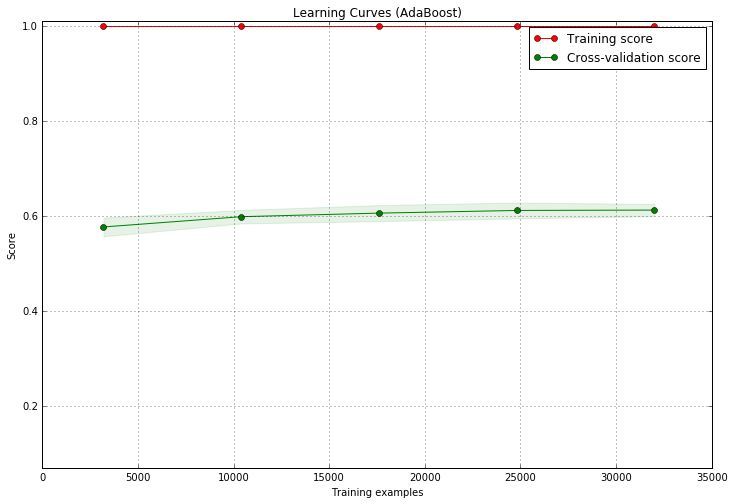

In [56]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import adaBoostClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = train_data[predictors + ['cluster']]
y = train_data[target_var]


title = "Learning Curves (GradientBoosting)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier(n_estimators=200)
plot_learning_curve(estimator, title, X, y, (0.07, 1.01), cv=cv, n_jobs=-2)

plt.show()

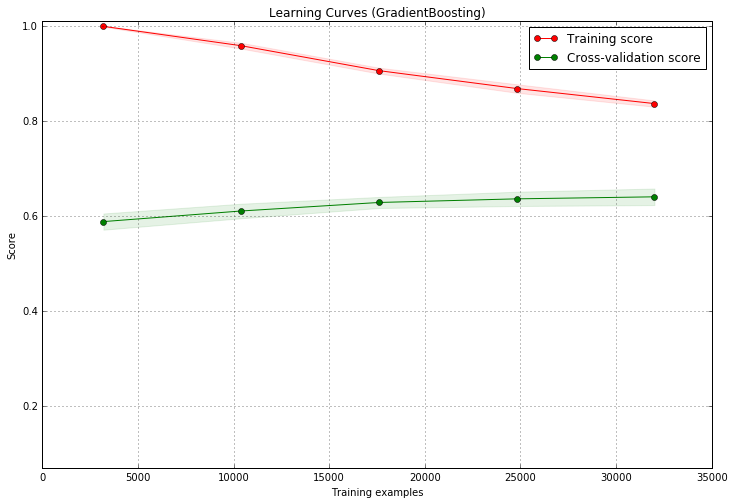

In [9]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import GradientBoostingClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = train_data[predictors]
y = train_data[target_var]


title = "Learning Curves (GradientBoosting)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier(n_estimators=200)
plot_learning_curve(estimator, title, X, y, (0.07, 1.01), cv=cv, n_jobs=-2)

plt.show()

[  4   8  16  32  64 128]


[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.1min finished


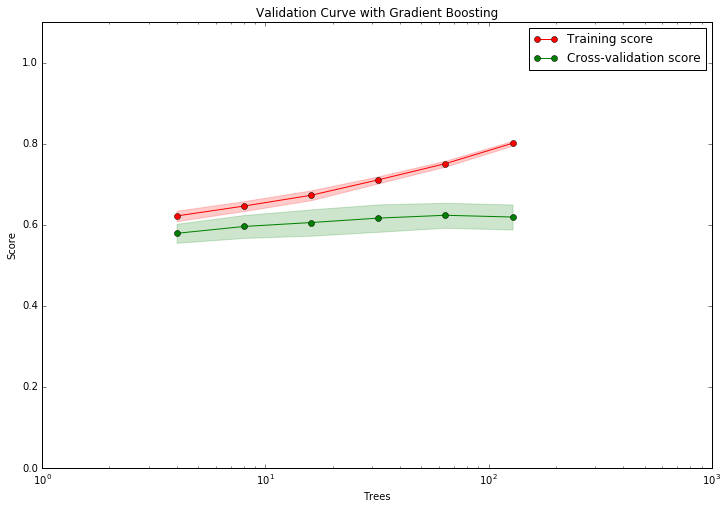

In [17]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = np.logspace(2, 7, 6, base=2).astype('int')
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(), X, y, param_name="n_estimators", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Trees")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[2, 4, 6, 8, 10, 12, 14]


[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed: 13.5min finished


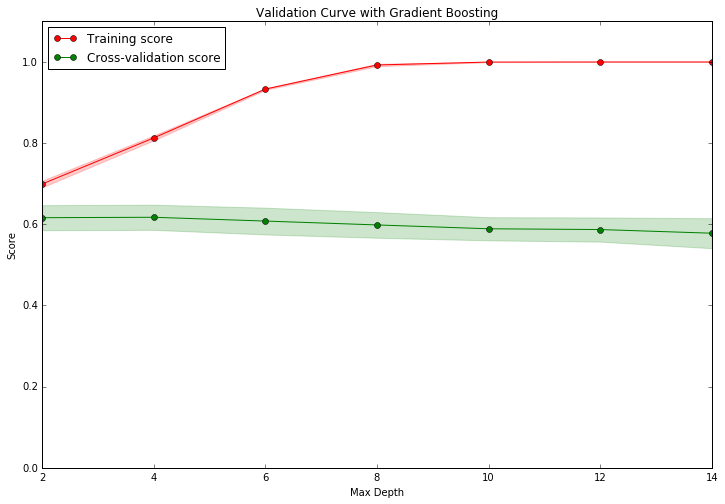

In [7]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = list(range(2, 16, 2))
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64), X, y, param_name="max_depth", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[   4    8   16   32   64  128  256  512 1024 2048]


[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  3.5min finished


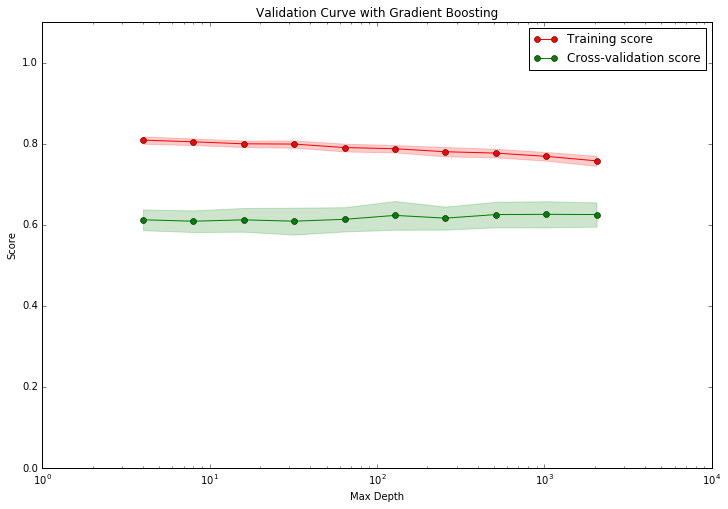

In [10]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = np.logspace(2, 11, 10, base=2).astype('int')
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64, max_depth=4), X, y, param_name="min_samples_split", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Minimum Samples Split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[1, 11, 21, 31, 41, 51, 61, 71]


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  2.9min finished


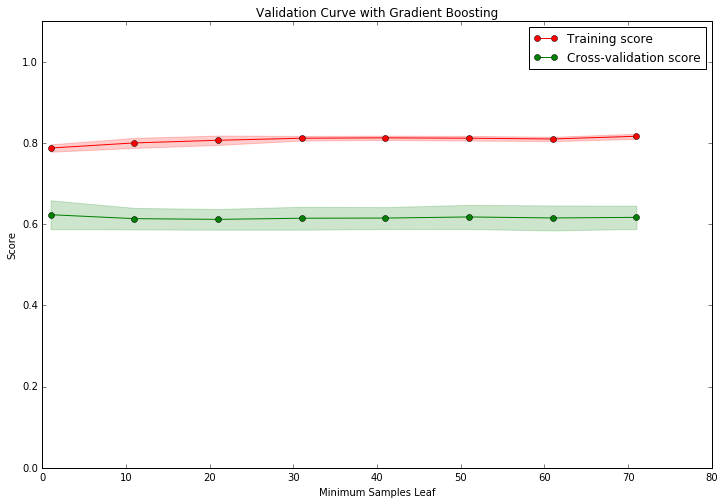

In [11]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = list(range(1, 72, 10))
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64, max_depth=4, min_samples_split=128), X, y, param_name="min_samples_leaf", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Minimum Samples Leaf")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[6, 8, 10, 12, 14, 16, 18]


[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:   38.8s finished


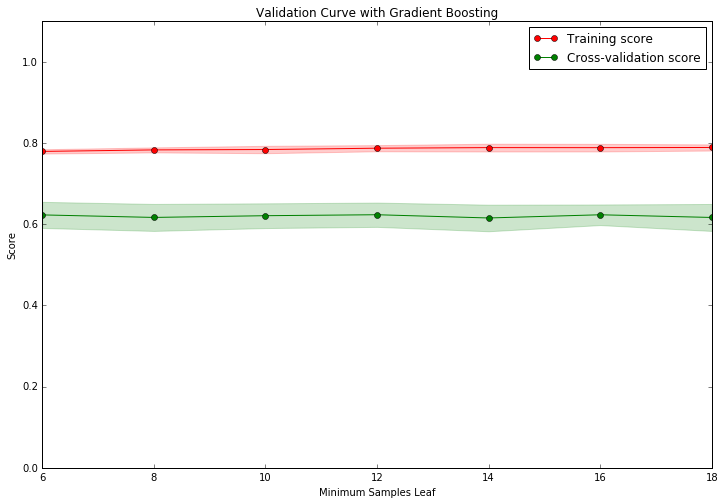

In [12]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = list(range(6, 20, 2))
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64, max_depth=4, min_samples_split=128), X, y, param_name="max_features", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Max Features per Tree")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[ 0.00390625  0.0078125   0.015625    0.03125     0.0625      0.125       0.25
  0.5         1.        ]


[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed: 10.2min finished


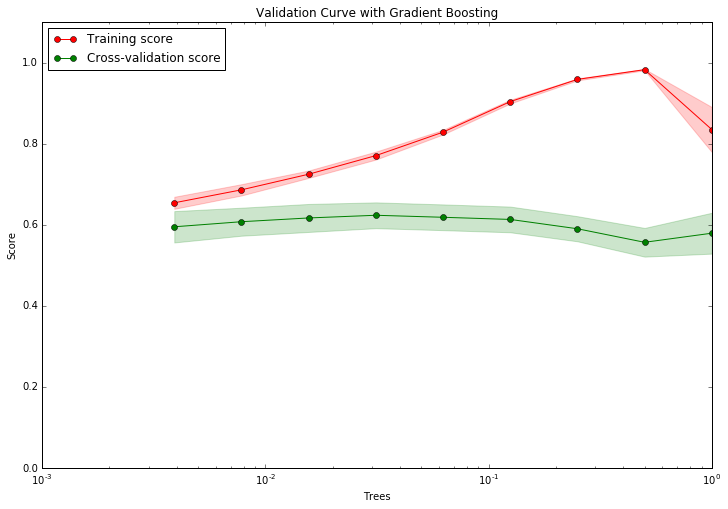

In [15]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = np.logspace(-7, 1, 9, base=2)
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=300), X, y, param_name="learning_rate", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedShuffleSplit

classifiers = ('gbc', GradientBoostingClassifier(n_estimators = 64, random_state=1))

#X = train_data[selected_columns + ['cluster']] 
#X = train_data[business_vars + ['cluster']]

params = [{'gbc__max_depth': list(range(2, 16, 2)), 'gbc__min_samples_split': list(range(1, 502, 100))}]
preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             algorithms=[[classifiers]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing gbc
Preparing to fit
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-2)]: Done 210 out of 210 | elapsed: 55.3min finished


Fitting completed
Best parameters set found on development set:
{'gbc__max_depth': 12, 'gbc__min_samples_split': 501}
Best score set found on development set:
0.662371563574
Grid scores on development set:

0.634 (+/-0.042) for {'gbc__max_depth': 2, 'gbc__min_samples_split': 1}
0.634 (+/-0.076) for {'gbc__max_depth': 2, 'gbc__min_samples_split': 101}
0.622 (+/-0.039) for {'gbc__max_depth': 2, 'gbc__min_samples_split': 201}
0.630 (+/-0.047) for {'gbc__max_depth': 2, 'gbc__min_samples_split': 301}
0.614 (+/-0.034) for {'gbc__max_depth': 2, 'gbc__min_samples_split': 401}
0.611 (+/-0.034) for {'gbc__max_depth': 2, 'gbc__min_samples_split': 501}
0.636 (+/-0.033) for {'gbc__max_depth': 4, 'gbc__min_samples_split': 1}
0.629 (+/-0.015) for {'gbc__max_depth': 4, 'gbc__min_samples_split': 101}
0.640 (+/-0.037) for {'gbc__max_depth': 4, 'gbc__min_samples_split': 201}
0.645 (+/-0.024) for {'gbc__max_depth': 4, 'gbc__min_samples_split': 301}
0.637 (+/-0.015) for {'gbc__max_depth': 4, 'gbc__min_samp

In [ ]:
classifiers = ('gbc', GradientBoostingClassifier(n_estimators = 64, random_state=1, max_depth=8))

#X = train_data[selected_columns + ['cluster']] 
#X = train_data[business_vars + ['cluster']]

params = [{'gbc__min_samples_split': list(range(600, 1401, 200)), 'gbc__min_samples_leaf': list(range(21, 72, 10))}]
preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             algorithms=[[classifiers]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=10, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing gbc
Preparing to fit
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [29]:
classifiers = ('gbc', GradientBoostingClassifier(n_estimators = 64, random_state=1, max_depth=5, min_samples_split=800,
                                                min_samples_leaf=51))

#X = train_data[selected_columns + ['cluster']] 
#X = train_data[business_vars + ['cluster']]

params = [{'gbc__max_features': list(range(6, 20, 2))}]
preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             algorithms=[[classifiers]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=20, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing gbc
Preparing to fit
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-2)]: Done  70 out of  70 | elapsed:  1.7min finished


Fitting completed
Best parameters set found on development set:
{'gbc__max_features': 14}
Best score set found on development set:
0.643846864261
Grid scores on development set:

0.641 (+/-0.065) for {'gbc__max_features': 6}
0.624 (+/-0.059) for {'gbc__max_features': 8}
0.641 (+/-0.048) for {'gbc__max_features': 10}
0.635 (+/-0.030) for {'gbc__max_features': 12}
0.644 (+/-0.056) for {'gbc__max_features': 14}
0.627 (+/-0.029) for {'gbc__max_features': 16}
0.629 (+/-0.043) for {'gbc__max_features': 18}



In [30]:
classifiers = ('gbc', GradientBoostingClassifier(n_estimators = 6, random_state=1, max_depth=5, min_samples_split=800,
                                                min_samples_leaf=51, max_features=10))

#X = train_data[selected_columns + ['cluster']] 
#X = train_data[business_vars + ['cluster']]

params = [{'gbc__subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}]
preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             algorithms=[[classifiers]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=10, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing gbc
Preparing to fit
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:  1.4min finished


Fitting completed
Best parameters set found on development set:
{'gbc__subsample': 0.7}
Best score set found on development set:
0.64614347079
Grid scores on development set:

0.636 (+/-0.041) for {'gbc__subsample': 0.6}
0.646 (+/-0.043) for {'gbc__subsample': 0.7}
0.629 (+/-0.048) for {'gbc__subsample': 0.75}
0.636 (+/-0.057) for {'gbc__subsample': 0.8}
0.639 (+/-0.026) for {'gbc__subsample': 0.85}
0.641 (+/-0.035) for {'gbc__subsample': 0.9}



In [7]:
classifiers = ('gbc', GradientBoostingClassifier(n_estimators = 1200, random_state=1, max_depth=4, min_samples_split=128))

#X = train_data[selected_columns + ['cluster']] 
#X = train_data[business_vars + ['cluster']]

params = [{'gbc__learning_rate': [0.0078]}]
preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             algorithms=[[classifiers]], parameters=params, preliminary_steps=preliminary_steps,
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing gbc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  8.6min finished


Fitting completed
Best parameters set found on development set:
{'gbc__learning_rate': 0.0078}
Best score set found on development set:
0.641762421249
Grid scores on development set:

0.642 (+/-0.036) for {'gbc__learning_rate': 0.0078}



In [11]:
from sklearn.cross_validation import StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import cross_validation

clf = XGBClassifier(scale_pos_weight=32.3, learning_rate=0.05, n_estimators=200)

X_trainP, X_testP, Y_trainP, Y_testP = cross_validation.train_test_split(train_data[predictors],
                                                                         train_data[target_var], 
                                                                         test_size = 0.15,
                                                                         stratify=train_data[target_var])

kf = cross_validation.StratifiedShuffleSplit(Y_trainP, n_iter=5, test_size=0.2)

scores = list()
for train_indices, test_indices in kf:
    print("Training fold")
    X_train, X_test = X_trainP.iloc[train_indices], X_trainP.iloc[test_indices]
    Y_train, Y_test = Y_trainP.iloc[train_indices], Y_trainP.iloc[test_indices]
    
    clf.fit(X_train, Y_train, eval_metric='auc')
    
    predictions = clf.predict_proba(X_test.astype(float))
    score = metrics.roc_auc_score(Y_test, predictions[:, 1])
    scores.append(score)

print ("ROC AUC:", np.mean(scores), "(+/-", np.std(scores), ")")

clf = clf.fit(X_trainP, Y_trainP, eval_metric='auc')
predictions = clf.predict_proba(X_testP.astype(float))
print ("ROC AUC sobre test set:", metrics.roc_auc_score(Y_testP, predictions[:, 1]))

Training fold
Training fold
Training fold
Training fold
Training fold
ROC AUC: 0.634084828595 (+/- 0.0108585074944 )
ROC AUC sobre test set: 0.592840778923


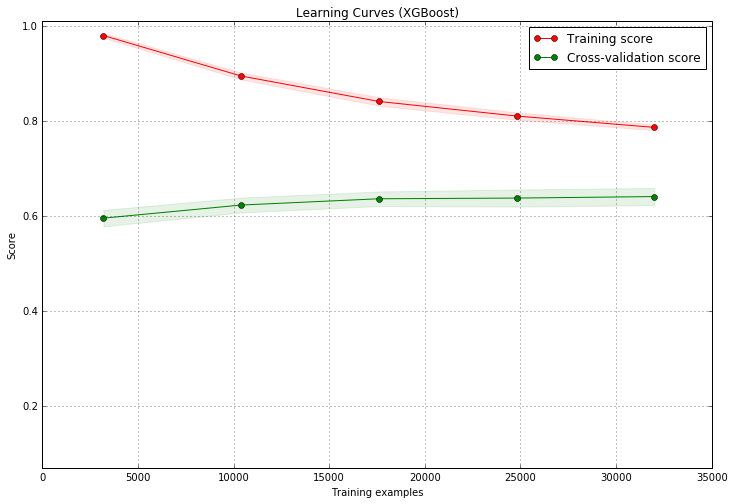

In [11]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import GradientBoostingClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = train_data[predictors]
y = train_data[target_var]


title = "Learning Curves (XGBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = XGBClassifier(scale_pos_weight=32.3)
plot_learning_curve(estimator, title, X, y, (0.07, 1.01), cv=cv, n_jobs=-2)

plt.show()

[  1.00000000e-02   4.64158883e-02   2.15443469e-01   1.00000000e+00
   4.64158883e+00   2.15443469e+01   1.00000000e+02   4.64158883e+02
   2.15443469e+03   1.00000000e+04]


[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  2.7min finished


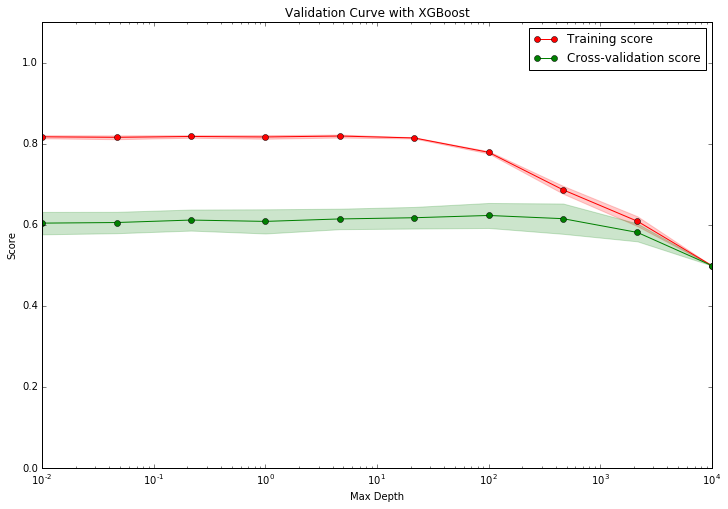

In [17]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors]
y = train_data[target_var]

param_range = np.logspace(2, 4, 10, base=10)
print(param_range)
train_scores, test_scores = validation_curve(
    XGBClassifier(scale_pos_weight=32), X, y, param_name="reg_alpha", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()